In [19]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.transforms import v2
import torch
from torchvision import datasets, transforms as T
from torchvision.datasets import wrap_dataset_for_transforms_v2
import utils
import torch.nn.functional as F
from torchvision.ops import box_convert
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm



In [2]:
data_filepath = '/Users/veb/ms/nanoDETR/data'
transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.VOCDetection(root = data_filepath, 
                                year = '2012', 
                                image_set = 'train', 
                                download = False,
                                transform = transform) 
train_dataset = wrap_dataset_for_transforms_v2(train_dataset)
img, target = train_dataset[0]
utils.v2show(img)

In [3]:
def collate_fn(batch):
    return batch

dl = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
samples = next(iter(dl))
img, target = samples[0]
utils.v2show(img)

In [4]:
data_filepath = '/Users/veb/ms/nanoDETR/data'
transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
dataset = datasets.VOCDetection(root = data_filepath, 
                                year = '2012', 
                                image_set = 'val', 
                                download = False,
                                transform = transform) 
dataset = wrap_dataset_for_transforms_v2(dataset)
img, target = dataset[1]
#utils.v2show(img)

In [20]:
def eval_map(model, idxes, dataset):
    preds = []
    gt = [] 
    
    for idx in tqdm(idxes):
        img, target = dataset[idx]
        _, H, W = img.shape
        frac = torch.tensor([W,H,W,H])
        gt_boxes = target['boxes'].data / frac # 0-1 scale
        gt_labels = target['labels']
        
        with torch.no_grad():
            logits, boxes = model(img)
            
        logits = logits.squeeze()
        boxes = boxes.squeeze()
            
        all_pred_labels = logits.argmax(dim = -1, keepdim = True)
        scores = F.softmax(logits, dim = -1).max(dim = -1).values 
    
        _boxes = []
        _scores = []
        _labels = []
        for i, label in enumerate(all_pred_labels):
            if label != 20:
                _boxes.append(boxes[i])
                _scores.append(scores[i])
                _labels.append(label)

        if len(_boxes) > 0:
            _boxes = torch.stack(_boxes, dim = 0)
            _boxes = box_convert(boxes = _boxes, in_fmt = 'cxcywh', out_fmt = 'xyxy') 
            _scores = torch.stack(_scores, dim = 0).view(-1)
            _labels = torch.stack(_labels, dim = 0).view(-1)
            preds.append({'boxes': _boxes, 'scores': _scores, 'labels': _labels})
        else:
            preds.append({'boxes': torch.zeros((0, 4)), 'scores': torch.zeros((0,)), 'labels': torch.zeros((0,), dtype=torch.long)})
            
        gt.append({'boxes': gt_boxes, 'labels': gt_labels})

    
    # Initialize metric
    metric = MeanAveragePrecision(iou_type="bbox")
    
    # Update metric with predictions and respective ground truth
    metric.update(preds, gt)
    
    # Compute the results
    result = metric.compute()
    return result



In [21]:
model_filepath = '/Users/veb/ms/nanoDETR/saved_models/epoch9_20251107_201421.pth'
model = torch.load(model_filepath, weights_only=False)

In [23]:
eval_map(model, range(1000), dataset)

100%|███████████████████████| 1000/1000 [01:37<00:00, 10.25it/s]


{'map': tensor(0.0157),
 'map_50': tensor(0.0436),
 'map_75': tensor(0.0085),
 'map_small': tensor(0.0157),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0348),
 'mar_10': tensor(0.0424),
 'mar_100': tensor(0.0428),
 'mar_small': tensor(0.0428),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20], dtype=torch.int32)}

In [36]:
model_filepath = '/Users/veb/ms/nanoDETR/saved_models/epoch5_20251107_151011.pth'
model = torch.load(model_filepath, weights_only=False)
eval_map(model, range(1000), dataset)

100%|███████████████████████| 1000/1000 [01:37<00:00, 10.26it/s]


{'map': tensor(0.0061),
 'map_50': tensor(0.0147),
 'map_75': tensor(0.0042),
 'map_small': tensor(0.0061),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0114),
 'mar_10': tensor(0.0143),
 'mar_100': tensor(0.0144),
 'mar_small': tensor(0.0144),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20], dtype=torch.int32)}

In [37]:
model_filepath = '/Users/veb/ms/nanoDETR/saved_models/epoch0_20251106_220951.pth'
model = torch.load(model_filepath, weights_only=False)
eval_map(model, range(1000), dataset)

100%|███████████████████████| 1000/1000 [01:29<00:00, 11.13it/s]


{'map': tensor(0.),
 'map_50': tensor(0.),
 'map_75': tensor(0.),
 'map_small': tensor(0.),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.),
 'mar_100': tensor(0.),
 'mar_small': tensor(0.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20], dtype=torch.int32)}

Sample at idx 0
nqueries=100
bicycle 0.80


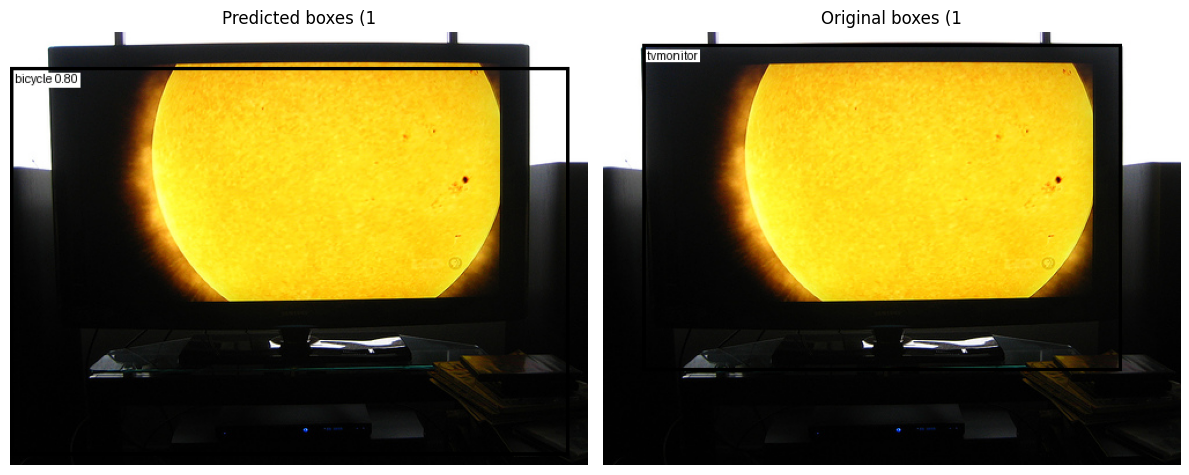

Sample at idx 1
nqueries=100
no pred boxes
Sample at idx 2
nqueries=100
no pred boxes
Sample at idx 3
nqueries=100
no pred boxes
Sample at idx 4
nqueries=100
no pred boxes
Sample at idx 5
nqueries=100
no pred boxes
Sample at idx 6
nqueries=100
person 0.82
person 0.79
person 0.78
person 0.58


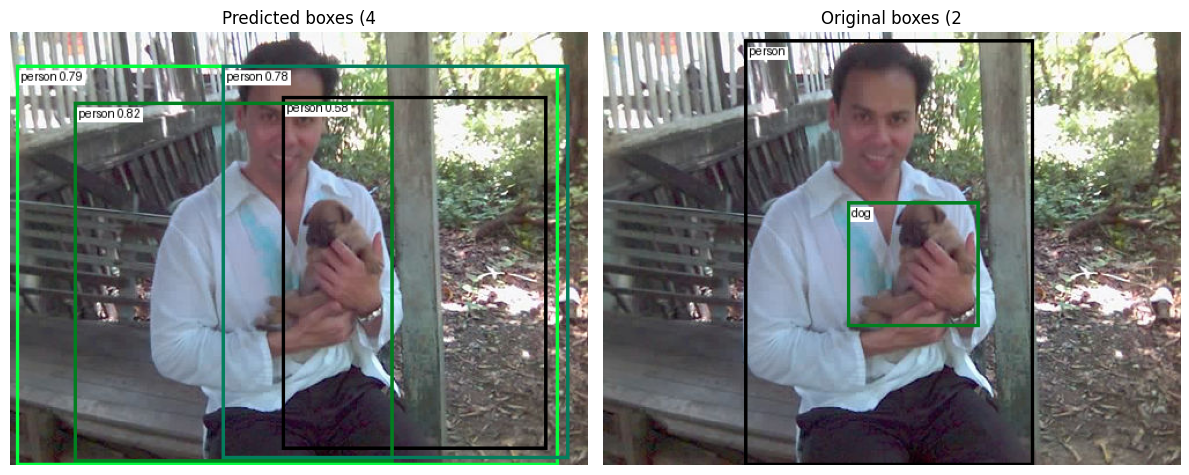

Sample at idx 7
nqueries=100
motorbike 0.50
motorbike 0.47


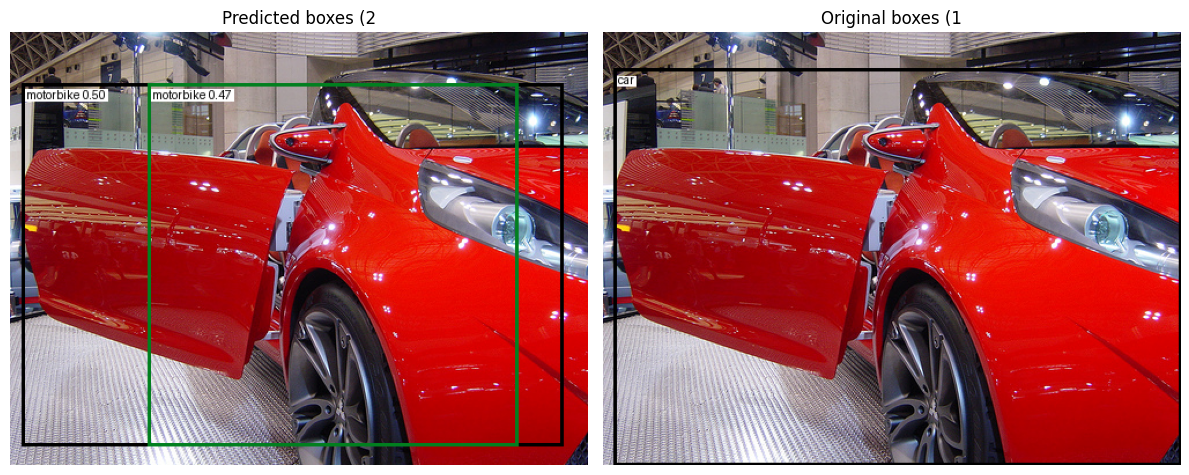

Sample at idx 8
nqueries=100
bus 0.40


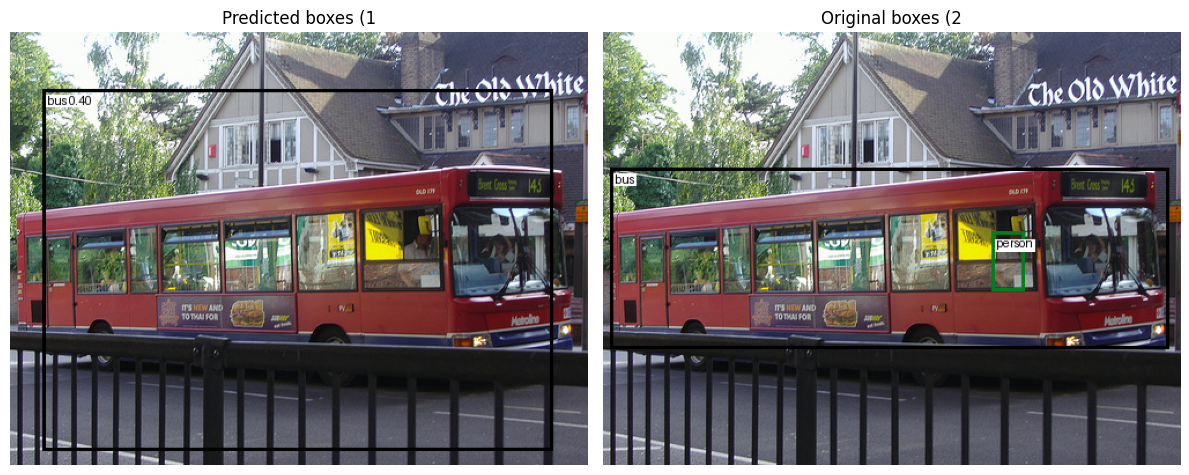

Sample at idx 9
nqueries=100
person 0.94
person 0.91
person 0.86
person 0.81
person 0.72
person 0.61
person 0.58
person 0.45


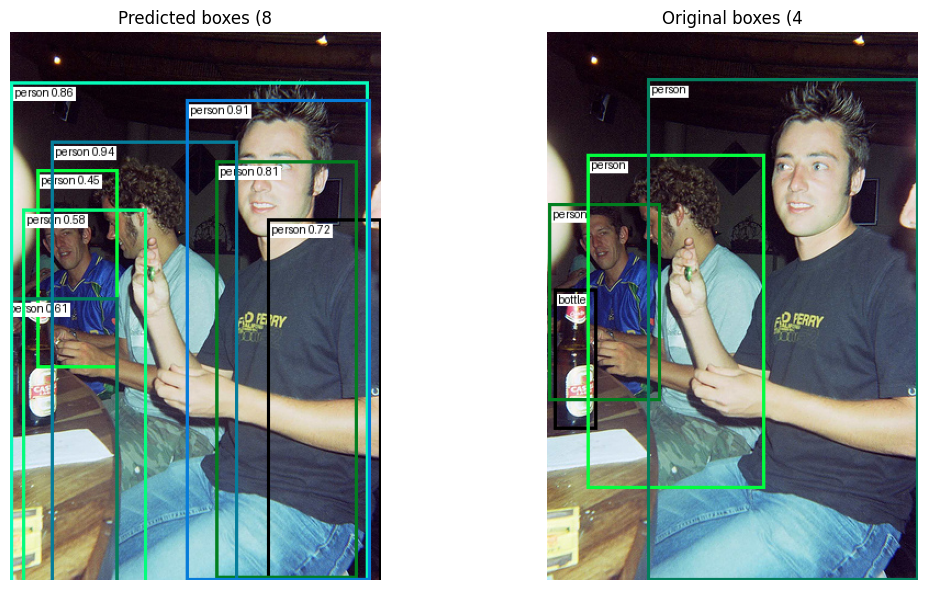

In [56]:
# go through first 10 - assess it works
model_filepath = '/Users/veb/ms/nanoDETR/saved_models/epoch9_20251107_201421.pth'
model = torch.load(model_filepath, weights_only=False)


def print_pred():
    for idx in range(10):
        print(f'Sample at idx {idx}')
        img, target = dataset[idx]
        logits, boxes = model(img)
        logits = logits.squeeze()
        boxes = boxes.squeeze()
        #utils.plot_pred(img, logits, boxes, savepath=None)
        utils.plot_pred_western(img, target, logits, boxes, False, savepath=None)
        #img.shape, target['boxes'].shape, logits.shape, boxes.shape

print_pred()